# Object Detetion

In [1]:
import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

import torch
import torchvision
import torchvision.models as models
from torchvision import transforms
from torch.utils import data

In [2]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

## Configure depth and color streams

In [3]:
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

In [4]:
# Start streaming
profile = pipeline.start(config)


for int in range(20):
    # Wait for a coherent pair of frames: depth and color
    frames = pipeline.wait_for_frames()

    depth_frame = frames.get_depth_frame()
    color_frame = frames.get_color_frame()

    # Convert images to numpy arrays
    depth_image = np.asanyarray(depth_frame.get_data())
    color_image = np.asanyarray(color_frame.get_data())

# Apply colormap on depth image (image must be converted to 8-bit per pixel first)
#depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

# Stack both images horizontally
#images = np.hstack((color_image, depth_image))


pipeline.stop()

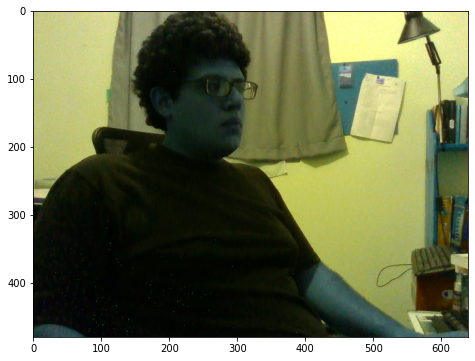

In [5]:
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color_image)

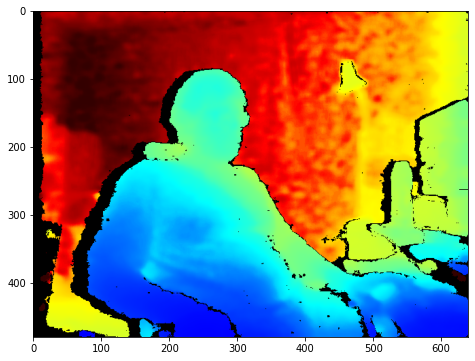

In [6]:
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth)

## Test Inception Pretrainded

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
color_image.shape

(480, 640, 3)

In [9]:
x = transform(color_image)

In [10]:
faster_r_cnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [11]:
faster_r_cnn.cuda()
faster_r_cnn.eval()

with torch.no_grad():
    prediction = faster_r_cnn(x.view(1,3,480,640).cuda())

In [12]:
prediction

[{'boxes': tensor([[355.6689,  36.2091, 615.7721, 472.8959],
          [151.3261,  70.8539, 566.5726, 474.5710],
          [157.2864,   0.0000, 640.0000, 232.0331],
          [  0.0000, 112.5620, 496.7350, 476.1382]], device='cuda:0'),
  'labels': tensor([ 1,  1,  3, 62], device='cuda:0'),
  'scores': tensor([0.1079, 0.1061, 0.1052, 0.0649], device='cuda:0')}]

In [13]:
prediction[0]['boxes']

tensor([[355.6689,  36.2091, 615.7721, 472.8959],
        [151.3261,  70.8539, 566.5726, 474.5710],
        [157.2864,   0.0000, 640.0000, 232.0331],
        [  0.0000, 112.5620, 496.7350, 476.1382]], device='cuda:0')

person
0.10611128
[151.3261   70.85391 566.57263 474.571  ]
415.24652
403.7171


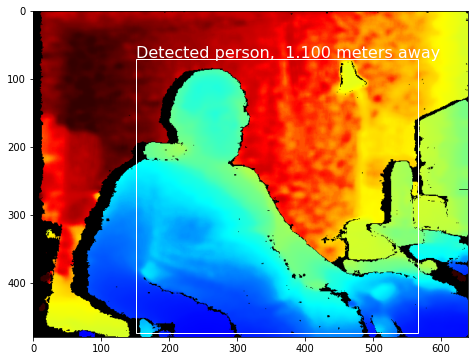

In [32]:
fig,ax = plt.subplots(1)

ax.imshow(colorized_depth, aspect='equal')

for index, bbox in enumerate(prediction[0]['boxes']):
    box = bbox.cpu().numpy()
    label_index = prediction[0]['labels'].cpu().numpy()[index]
    label = COCO_INSTANCE_CATEGORY_NAMES[label_index]
    score = label_index = prediction[0]['scores'].cpu().numpy()[index]
    
    if score < 0.107 and label == 'person':
        print(label)
        print(score)
        print(box)
        print(box[2] - box[0])
        print(box[3] - box[1])
        
        xmin_depth = np.int16(box[0]).item()
        xmax_depth = np.int16(box[2]).item()
        ymin_depth = np.int16(box[1]).item()
        ymax_depth = np.int16(box[3]).item()
        
        #### DISTANCE ######
        depth = np.asanyarray(depth_frame.get_data())
        depth = depth[xmin_depth:xmax_depth,ymin_depth:ymax_depth].astype(float)
        # Get data scale from the device and convert to meters
        depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
        depth = depth * depth_scale
        distance = np.mean(depth)
        
        ax.add_patch(
            plt.Rectangle((box[0], box[1]),
                     box[2] - box[0],
                     box[3] - box[1],
                     fill=False,
                     edgecolor='white')
        )
        ax.text(bbox[0],bbox[1] - 2,
                'Detected {0},  {1:.3f} meters away'.format(label, distance),fontsize=16,color='white')
        
    
plt.draw()